## Case 1: Forecasting for Airports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.preprocessing import OneHotEncoder
import scipy.linalg as lng # linear algebra from scipy library
from sklearn import preprocessing as preproc # load preprocessing function
from pathlib import Path

from sklearn.feature_selection import RFE
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

import warnings
warnings.filterwarnings("ignore")


In [2]:
df = pd.read_excel('Case1_data.xlsx')
print('Number of features:',df.shape[1]-1)
print('Number of observations:',df.shape[0])

Number of features: 8
Number of observations: 39449


In [3]:
X=df[['Airline','FlightNumber','Destination','AircraftType','FlightType','Sector','SeatCapacity']]
y=df[['LoadFactor']]

# Get number of observations (n=39449) and number of independent variables (p=8 attributes)
[n, p] = np.shape(X)

## Preprocessing

First, we are are checking if there are missing values in our dataset. 

In [4]:
for el in df:
    print(el,sum(df[el].isnull()))

ScheduleTime 0
Airline 0
FlightNumber 0
Destination 0
AircraftType 0
FlightType 0
Sector 0
SeatCapacity 0
LoadFactor 0


**Separating Time**:

In [5]:
DateTime_dic = {'Day':[],'Month':[],'Year':[],'Hour':[],'Minute':[],'Dayofweek':[],'Dayofyear':[],'Quarter':[],
               'QuarterStart':[],'QuarterEnd':[],'MonthStart':[],'MonthEnd':[],'YearStart':[],'YearEnd':[]}

for a in df['ScheduleTime']:
    DateTime_dic['Day'].append(a.day)
    DateTime_dic['Month'].append(a.month)
    DateTime_dic['Year'].append(a.year)
    DateTime_dic['Hour'].append(a.hour)
    DateTime_dic['Minute'].append(a.minute)
    DateTime_dic['Dayofweek'].append(a.dayofweek)
    DateTime_dic['Dayofyear'].append(a.dayofyear)
    DateTime_dic['Quarter'].append(int(a.quarter))
    DateTime_dic['QuarterStart'].append(int(a.is_quarter_start))
    DateTime_dic['QuarterEnd'].append(int(a.is_quarter_end))
    DateTime_dic['MonthStart'].append(int(a.is_month_start))
    DateTime_dic['MonthEnd'].append(int(a.is_month_end))
    DateTime_dic['YearStart'].append(int(a.is_year_start))
    DateTime_dic['YearEnd'].append(int(a.is_year_end))
    
    
pd_time=pd.DataFrame.from_dict(DateTime_dic)

X_all=X.join(pd_time)
X_all.AircraftType=X_all.AircraftType.astype('str')
X_all.Year=X_all.Year.astype('str')


#X_all.Day=X_all.Day.astype('str')
#X_all.Month=X_all.Month.astype('str')

#Let's try if it improved our error. 
#By putting the following variables as strings, the error improved. But then we have more variables. 
#X_all.Hour=X_all.Hour.astype('str')
#X_all.Minute=X_all.Minute.astype('str')
#X_all.FlightNumber=X_all.FlightNumber.astype('str')

print(X_all.dtypes)
X_all

Airline         object
FlightNumber     int64
Destination     object
AircraftType    object
FlightType      object
Sector          object
SeatCapacity     int64
Day              int64
Month            int64
Year            object
Hour             int64
Minute           int64
Dayofweek        int64
Dayofyear        int64
Quarter          int64
QuarterStart     int64
QuarterEnd       int64
MonthStart       int64
MonthEnd         int64
YearStart        int64
YearEnd          int64
dtype: object


,Airline,FlightNumber,Destination,AircraftType,FlightType,Sector,SeatCapacity,Day,Month,Year,...,Minute,Dayofweek,Dayofyear,Quarter,QuarterStart,QuarterEnd,MonthStart,MonthEnd,YearStart,YearEnd
0,IA,874,DEN,73W,J,US,142,1,1,2021,...,35,4,1,1,1,0,1,0,1,0
1,JZ,818,YHM,AT7,J,CA,74,1,1,2021,...,35,4,1,1,1,0,1,0,1,0
2,IA,876,DEN,73W,J,US,142,1,1,2021,...,5,4,1,1,1,0,1,0,1,0
3,CN,514,EST,AT7,J,US,72,1,1,2021,...,20,4,1,1,1,0,1,0,1,0
4,LJ,3140,DEN,32A,J,US,186,1,1,2021,...,20,4,1,1,1,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39444,VW,986,YYZ,319,J,CA,144,28,2,2022,...,45,0,59,1,0,0,0,1,0,0
39445,LJ,667,YDQ,319,J,CA,156,28,2,2022,...,25,0,59,1,0,0,0,1,0,0
39446,VW,3406,MYV,E90,J,US,98,28,2,2022,...,0,0,59,1,0,0,0,1,0,0
39447,LJ,663,RUT,32N,J,US,186,28,2,2022,...,30,0,59,1,0,0,0,1,0,0


In [6]:
def count_features(df,feature):
    unique_features= np.unique(df[[feature]])
    list_count_features=[]
    Feature_df=df[[feature]]
    
    for x in unique_features:
        count=Feature_df[Feature_df[feature] == x].count()
        list_count_features.append((x,count[0]))
        
    return list_count_features

In [7]:
AL=count_features(X_all,'Airline')
print('Number of unique Airlines in the Dataset:',len(AL))
AL.sort(key=lambda AL:AL[1],reverse=True)
print(AL)
print('\n')
FN=count_features(X_all,'FlightNumber')
print('Number of unique Flight Number in the Dataset:',len(FN))
FN.sort(key=lambda FN:FN[1],reverse=True)
print(FN)
print('\n')
D=count_features(X_all,'Destination')
print('Number of unique Destinations:',len(D))
D.sort(key=lambda D:D[1],reverse=True)
print(D)
print('\n')
AT=count_features(X_all,'AircraftType')
print('Number of unique Aircraft Types:',len(AT))
AT.sort(key=lambda AT:AT[1],reverse=True)
print(AT)
print('\n')
FT=count_features(X_all,'FlightType')
print('Number of unique Flight Types:',len(FT))
FT.sort(key=lambda FT:FT[1],reverse=True)
print(FT)
print('\n')
S=count_features(X_all,'Sector')
print('Number of unique Sectors:',len(S))
S.sort(key=lambda S:S[1],reverse=True)
print(S)
print('\n')
SC=count_features(X_all,'SeatCapacity')
print('Number of Seat Capacity:',len(SC))
SC.sort(key=lambda SC:SC[1],reverse=True)
print(SC)
print('\n')
Day=count_features(X_all,'Day')
print('Number of Days:',len(Day))
Day.sort(key=lambda Day:Day[1],reverse=True)
print(Day)
print('\n')
MO=count_features(X_all,'Month')
print('Number of Months:',len(MO))
MO.sort(key=lambda MO:MO[1],reverse=True)
print(MO)
print('\n')
YE=count_features(X_all,'Year')
print('Number of Years:',len(YE))
YE.sort(key=lambda YE:YE[1],reverse=True)
print(YE)
print('\n')
HO=count_features(X_all,'Hour')
print('Number of Hours:',len(HO))
HO.sort(key=lambda HO:HO[1],reverse=True)
print(HO)
print('\n')
MIN=count_features(X_all,'Minute')
print('Number of Minutes:',len(MIN))
MIN.sort(key=lambda MIN:MIN[1],reverse=True)
print(MIN)
print('\n')
DWeek=count_features(X_all,'Dayofweek')
print('Number of DayofWeek:',len(DWeek))
DWeek.sort(key=lambda DWeek:DWeek[1],reverse=True)
print(DWeek)
print('\n')
DYear=count_features(X_all,'Dayofyear')
print('Number of DayofYear:',len(DYear))
DYear.sort(key=lambda DYear:DYear[1],reverse=True)
print(DYear)
print('\n')
QUA=count_features(X_all,'Quarter')
print('Number of Quarters:',len(QUA))
QUA.sort(key=lambda QUA:QUA[1],reverse=True)
print(QUA)
print('\n')
LF=count_features(df,'LoadFactor')
print('LoadFactor:',len(LF))
LF.sort(key=lambda LF:LF[0])
print('Range LoadFactor:',LF[0][0],'to',LF[-1][0])


Number of unique Airlines in the Dataset: 105
[('DO', 10483), ('CL', 4580), ('LJ', 3572), ('CN', 2526), ('ZY', 1850), ('VW', 1812), ('IA', 1388), ('LZ', 1220), ('SV', 1181), ('UK', 1124), ('PW', 822), ('GQ', 492), ('JZ', 489), ('IR', 474), ('KL', 402), ('ZD', 393), ('AY', 377), ('MD', 375), ('TN', 374), ('ML', 364), ('PU', 329), ('NH', 325), ('ZT', 318), ('KU', 306), ('NV', 303), ('IK', 272), ('EM', 256), ('NU', 240), ('MC', 203), ('BJ', 184), ('FP', 176), ('PO', 164), ('SH', 158), ('BT', 155), ('OK', 132), ('VD', 126), ('LW', 122), ('NI', 95), ('WT', 95), ('KN', 90), ('OF', 90), ('QU', 80), ('YU', 70), ('RT', 67), ('BZ', 62), ('ZL', 60), ('WN', 56), ('GM', 50), ('PJ', 50), ('ZP', 49), ('SQ', 44), ('TJ', 44), ('FZ', 39), ('YT', 37), ('FO', 26), ('WU', 26), ('NW', 24), ('WR', 20), ('KJ', 18), ('PL', 18), ('XA', 15), ('NS', 13), ('RS', 13), ('UI', 12), ('JN', 11), ('VJ', 11), ('JA', 8), ('LX', 8), ('KZ', 7), ('RZ', 7), ('WJ', 6), ('YQ', 6), ('E4', 5), ('EN', 4), ('TV', 4), ('DU', 3), ('F

Number of unique Destinations: 230
[('CKE', 2706), ('DEN', 1813), ('YYZ', 1655), ('YXC', 1557), ('YYJ', 1423), ('EST', 1242), ('YLW', 1182), ('YVR', 917), ('YQR', 765), ('YXU', 709), ('YHM', 642), ('YEG', 638), ('YFI', 572), ('YKF', 533), ('YXX', 514), ('YXJ', 499), ('YQU', 491), ('YCD', 489), ('YZF', 481), ('KEF', 479), ('YKA', 449), ('KWT', 444), ('PHX', 444), ('MYV', 427), ('RUT', 412), ('ZSW', 398), ('AUM', 395), ('YXT', 395), ('CYT', 392), ('YYG', 380), ('DOH', 372), ('MSP', 372), ('OFF', 369), ('YUL', 345), ('HFD', 340), ('RNH', 338), ('ASE', 335), ('KIC', 332), ('YAD', 325), ('GBR', 306), ('YQQ', 305), ('YXH', 299), ('YLL', 291), ('BWI', 285), ('ICL', 280), ('LAS', 279), ('DFW', 275), ('AIY', 265), ('YWG', 262), ('YBR', 260), ('YOW', 252), ('UTM', 240), ('YHZ', 237), ('SLK', 234), ('YDQ', 228), ('YJO', 225), ('ONL', 215), ('EWR', 213), ('ORD', 212), ('ICY', 209), ('DAN', 205), ('MJQ', 202), ('BPT', 201), ('YKK', 198), ('ASH', 188), ('DAB', 184), ('DXB', 176), ('FTL', 171), ('MOD

LoadFactor: 4732
Range LoadFactor: 0.0 to 1.47517730496453


**Encode all the string variables**:

In [8]:
features= 1+1+105+230+58+3+12+31+12+2+1+1
print('Our complete dataset would be of',features,'features.')

X_ext= X_all.copy()
SC_non_norm=np.array(X_ext['SeatCapacity'])

#Variables that we need to encode: 
str_var=list(X_all.select_dtypes(include='object').columns)
print(str_var)
X_ext=X_ext.drop(columns=str_var)


Our complete dataset would be of 457 features.
['Airline', 'Destination', 'AircraftType', 'FlightType', 'Sector', 'Year']


In [9]:
for var in str_var:
    # creating instance of one-hot-encoder
    enc = OneHotEncoder(handle_unknown='ignore')
    # passing bridge-types-cat column (label encoded values of bridge_types)
    unique_var= list(np.unique(X_all[[var]]))
    enc_df = pd.DataFrame(enc.fit_transform(X_all[[var]]).toarray())
    
    for col in enc_df:
        enc_df=enc_df.rename(columns = {col:var+unique_var[col]})

    #Join dataframes
    X_ext = pd.concat([X_ext,enc_df], axis = 1)
    

**Normalization of int features**:

In [10]:
def normalizeData(data):
    mu = np.mean(data,axis=0)
    omega = np.std(data,axis=0)
    data = (data - mu)/omega
    
    return data, mu
 
    
def centerData(data): 
    mu = np.mean(data,axis=0)
    data = data - mu
    
    return data, mu

In [11]:
SC_non_norm=np.array(X_ext['SeatCapacity'])
SC_norm,mu=normalizeData(SC_non_norm)
X_ext.SeatCapacity= SC_norm 


X_ext.Hour= normalizeData(np.array(X_ext['Hour']))[0]
X_ext.Minute= normalizeData(np.array(X_ext['Minute']))[0]
X_ext.FlightNumber= normalizeData(np.array(X_ext['FlightNumber']))[0]
X_ext.Day= normalizeData(np.array(X_ext['Day']))[0]
X_ext.Month= normalizeData(np.array(X_ext['Month']))[0]


X_ext.Dayofweek= normalizeData(np.array(X_ext['Dayofweek']))[0]
X_ext.Dayofyear= normalizeData(np.array(X_ext['Dayofyear']))[0]
X_ext.Quarter= normalizeData(np.array(X_ext['Quarter']))[0]
X_ext=X_ext.drop(columns='Year2022')

X_ext


,FlightNumber,SeatCapacity,Day,Month,Hour,Minute,Dayofweek,Dayofyear,Quarter,QuarterStart,...,SectorDK,SectorEG,SectorIQ,SectorIS,SectorMX,SectorNL,SectorQA,SectorSG,SectorUS,Year2021
0,-0.405401,-0.232657,-1.674705,-1.676615,-1.508026,0.436489,0.471595,-1.796263,-1.50472,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
1,-0.482306,-1.392044,-1.674705,-1.676615,-0.656339,0.436489,0.471595,-1.796263,-1.50472,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,-0.402654,-0.232657,-1.674705,-1.676615,-0.230496,-1.308119,0.471595,-1.796263,-1.50472,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
3,-0.899791,-1.426144,-1.674705,-1.676615,-0.017574,-0.435815,0.471595,-1.796263,-1.50472,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
4,2.706509,0.517535,-1.674705,-1.676615,0.195348,-0.435815,0.471595,-1.796263,-1.50472,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39444,-0.251590,-0.198557,1.396789,-1.406481,1.047035,1.018025,-1.488417,-1.282912,-1.50472,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
39445,-0.689675,0.006040,1.396789,-1.406481,1.259957,-0.145047,-1.488417,-1.282912,-1.50472,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
39446,3.071808,-0.982849,1.396789,-1.406481,1.472879,-1.598887,-1.488417,-1.282912,-1.50472,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
39447,-0.695168,0.517535,1.396789,-1.406481,1.259957,0.145721,-1.488417,-1.282912,-1.50472,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [ ]:
#X_ext.to_csv('AllFeatures.csv',index=False) 


**Correlation of features**:

In [ ]:
corr_matrix = X_ext.corr()

In [ ]:
f = plt.figure(figsize=(8, 8))
plt.matshow(corr_matrix, fignum=f.number)
cb = plt.colorbar()
plt.title('Correlation Matrix', fontsize=12);

**Assessment functions**:

In [12]:
def compute_mse(X,beta,y):
    yhat = np.matmul(X, beta)
    res = (y - yhat) ** 2    
    mse = np.mean(res)
    
    return mse, res, yhat


def estimated_total_accuracy(y,y_esti,SC_non_norm):
    #Deviation per flight = (Actual passengers – Forecasted passengers) / Actual passengers per flight
    #Accuracy per flight = 100% - | Deviation per flight |
    
    Actual_pass=np.array(y).T*SC_non_norm
    Forecast_pass=np.array(y_esti).reshape((1, len(y_esti)))*SC_non_norm
    
    ind0=np.where(Actual_pass==0)[1]
    
    Actual_pass= np.delete(Actual_pass,ind0)
    Forecast_pass= np.delete(Forecast_pass,ind0)

    Dev= (np.abs(Actual_pass-Forecast_pass))/Actual_pass

    Exp_acc= 1- Dev
    T_exp_acc=np.mean(Exp_acc)*100

    return T_exp_acc

## Methods

### 0. Methods for Feature Selection: 
#### a) Backward Elimination:

cols = list(X_ext.columns)
pmax = 1
while (len(cols)>0):
    p= []
    X_1 = X_ext[cols]
    X_1 = sm.add_constant(X_1)
    model = sm.OLS(y,X_1).fit()
    p = pd.Series(model.pvalues.values[1:],index = cols)      
    pmax = max(p)
    feature_with_p_max = p.idxmax()
    if(pmax>0.05):
        cols.remove(feature_with_p_max)
    else:
        break
selected_features_BE = cols
print(selected_features_BE)

#### b) RFE (Recursive Feature Elimination)

from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE

#no of features
nof_list=np.arange(1,p)            
high_score=0
#Variable to store the optimum features
nof=0           
score_list =[]
for n in range(len(nof_list)):
    X_train, X_test, y_train, y_test = train_test_split(X_ext,y, test_size = 0.3, random_state = 0)
    model = LinearRegression()
    rfe = RFE(model,n_features_to_select = nof_list[n])
    X_train_rfe = rfe.fit_transform(X_train,y_train)
    X_test_rfe = rfe.transform(X_test)
    model.fit(X_train_rfe,y_train)
    score = model.score(X_test_rfe,y_test)
    score_list.append(score)
    if(score>high_score):
        high_score = score
        nof = nof_list[n]
    
print("Optimum number of features: %d" %nof)
print("Score with %d features: %f" % (nof, high_score))


cols = list(X_ext.columns)
model = LinearRegression()
#Initializing RFE model
rfe = RFE(model, n_features_to_select=nof)             
#Transforming data using RFE
X_rfe = rfe.fit_transform(X_ext,y)  
#Fitting the data to model
model.fit(X_rfe,y)              
temp = pd.Series(rfe.support_,index = cols)
selected_features_rfe = temp[temp==True].index
print((selected_features_rfe))

### 1. Ordinary Least Squares (OLS)

#### Feature Selection:

In [13]:
import statsmodels.api as sm

cols = list(X_ext.columns)
pmax = 1
while (len(cols)>0):
    p= []
    X_1 = X_ext[cols]
    X_1 = sm.add_constant(X_1)
    model = sm.OLS(y,X_1).fit()
    p = pd.Series(model.pvalues.values[1:],index = cols)      
    pmax = max(p)
    feature_with_p_max = p.idxmax()
    if(pmax>0.05):
        cols.remove(feature_with_p_max)
    else:
        break
selected_features_BE = cols


In [14]:
#SELECTED FEATURES 
print(len(selected_features_BE))
X_sel=X_ext[selected_features_BE].copy()

259


In [ ]:
#Without cross-validation   
X_train, X_test, y_train, y_test = train_test_split(X_sel,y, test_size = 0.3,random_state=42)

SC_non_norm_test=np.array(X_ext.SeatCapacity[y_test.index])

print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape) 
print(SC_non_norm_test.shape)


X_1 = sm.add_constant(X_train)
#Fitting sm.OLS model
model = sm.OLS(y_train,X_1).fit()

X_test1 = sm.add_constant(X_test)
y_pred=model.predict(X_test1)

T_ex_acc=estimated_total_accuracy(y_test,y_pred,SC_non_norm_test)
print('Total Expected Accuracy:',T_ex_acc)

In [15]:
X_sel_arr=np.array(X_sel)
y_arr=np.array(y)

#### 1.1 Model Selection for OLS Regression - K-fold Cross-Validation

In [51]:
#Using Cross-Validation

K=10
kf = KFold(n_splits=K)
Accuracy=np.zeros(K)
X_train_f=[]
y_train_f=[]
X_test_f=[]
y_test_f=[]
y_pred_f=[]

for i, (train_index, test_index) in enumerate(kf.split(X_sel_arr)):

    X_train = X_sel_arr[train_index]
    y_train = y_arr[train_index]
    X_test = X_sel_arr[test_index]
    y_test = y_arr[test_index]

    SC_non_norm_test=np.array(X_sel.SeatCapacity[test_index])
    
    
    X_1 = sm.add_constant(X_train)

    #Fitting sm.OLS model
    model = sm.OLS(y_train,X_1).fit()
    
    # predict model
    [m,n]=X_test.shape
    off = np.ones(m).reshape(m,1)
    X_test1=np.concatenate((off, X_test), axis=1)
    
    y_pred=model.predict(X_test1)
    
    X_train_f.append(X_1)
    y_train_f.append(y_train)
    X_test_f.append(X_test1)
    y_test_f.append(y_test)
    y_pred_f.append(y_pred)
    
    T_ex_acc=estimated_total_accuracy(y_test,y_pred,SC_non_norm_test)
    Accuracy[i]=T_ex_acc;
    print('Total Expected Accuracy:',T_ex_acc)

Total Expected Accuracy: 48.64240041688615
Total Expected Accuracy: 93.47059825079252
Total Expected Accuracy: 88.6808129705143
Total Expected Accuracy: 98.85349680861542
Total Expected Accuracy: 96.59361668668379
Total Expected Accuracy: 94.32693092669842
Total Expected Accuracy: 63.46827073507488
Total Expected Accuracy: 78.93267551171326
Total Expected Accuracy: 79.9748044265924
Total Expected Accuracy: 84.90414856498579


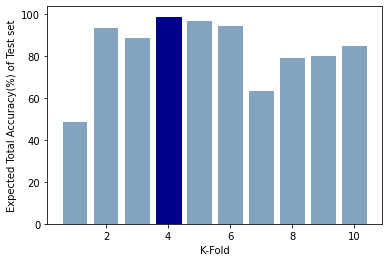

In [88]:
p=np.arange(1,K+1)
b=plt.bar(p,Accuracy,color=(0.2, 0.4, 0.6, 0.6))
b[3].set_color('darkblue')
plt.xlabel("K-Fold")
plt.ylabel("Expected Total Accuracy(%) of Test set")
plt.show()

In [65]:
#Select the kfold with the highest accuracy: 
ind_f=np.argmax(Accuracy)
print('Accuracy:',Accuracy[ind_f])

y_test=y_test_f[ind_f]
y_pred=y_pred_f[ind_f]


Accuracy: 98.85349680861542


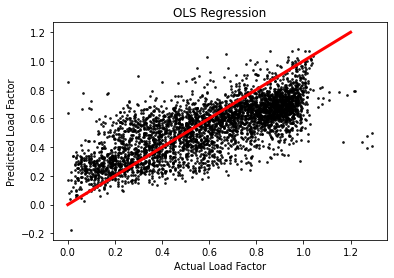

In [84]:
xx=np.linspace(0,1.2)

plt.scatter(y_test,y_pred,s=3,alpha=0.8,c ="black")
plt.plot(xx, xx, color='red', linewidth=3)
plt.ylabel('Predicted Load Factor')
plt.xlabel('Actual Load Factor')
plt.title('OLS Regression')
plt.show()

In [ ]:
def ols_numerical(X, y):
    # Call lstsq from lng to get betas
    betas, res, rnk, s = lng.lstsq(X, y)    
    return betas, res, rnk, s

In [ ]:
# Include offset / intercept
[n, p] = np.shape(X_ext)
print('Observations:',n,'and features:',p)
off = np.ones(n) 
M = np.c_[off, X_ext]
y=np.array(y)

# numerical solution
beta_num, res, rnk, s = ols_numerical(M, y)


### 2. Ridge Regression

In [93]:
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso, Lars

#### Feature Selection:

In [104]:
X_sel=X_sel

In [ ]:
def ridgeMulti(X, _lambda, p, y):
    inner_prod = np.linalg.inv(np.matmul(X.T, X) + _lambda * np.eye(p,p))
    outer_prod = np.matmul(X.T, y)
    betas = np.matmul(inner_prod, outer_prod)
    return betas

def estimate_betas(X, beta_true, sigma, _lambda):
    n, p = X.shape
    y = np.matmul(X, beta_true) + sigma*np.random.normal(size=n) # Measures response - true value plus noise level
    beta = ridgeMulti(X, _lambda, p, y) # Estimates
    return beta

#### 2.1 Model Selection for Ridge Regression - K-fold Cross-Validation

- Finding a suitable range of the shrinkage parameter in which to search for an optimal value. 

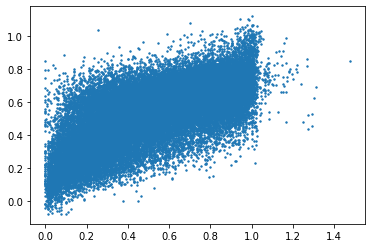

In [106]:
#CV
clf = Ridge(alpha=0.9)

clf.fit(X_sel_arr, y_arr)
y_pred=clf.predict(X_sel_arr)

plt.scatter(y_arr,y_pred,s=2)

In [91]:
k = 20; # try k values of lambda
lambdas = np.logspace(-4, 4, k)

betas = np.zeros((p,k))

for i in range(k):
    betas[:, i] = ridgeMulti(M[:,1:], lambdas[i], p, y).T
    
plt.figure()
plt.semilogx(lambdas, betas.T)
plt.xlabel("Lambdas")
plt.ylabel("Betas")
plt.suptitle("Regularized beta estimates", fontsize=12)
plt.show()

TypeError: only integer scalar arrays can be converted to a scalar index

The suitable range for $λ$ should be between *$10^{-3}$ and $10^{-1}$*.

Next, we are selecting a suitable value for the regularization parameter using **K-fold cross-validation.** 

In [ ]:
K = 10

#Create a vector of length n that contains equal amounts of numbers from 1 to K
I = np.asarray([0] * n) #array of 0 (number of features)
for i in range(n):
    I[i] = (i) % K + 1
    

#Permute that vector. 
I = I[np.random.permutation(n)]

lambdas = np.logspace(-3, 1, k)
MSE = np.zeros((K, 20))

M2=M[:,1:]
for i in range(1, K+1):
    #Select the train/test data in this fold
    XTrain = M2[i != I, :]
    yTrain = y[i != I]
    XTest = M2[i == I, :]
    yTest = y[i == I]
    
    #Fit ridgeregression
    for j in range(20):
        beta = ridgeMulti(XTrain, lambdas[j], p, yTrain)
        MSE[(i - 1), j] = np.mean((yTest - np.matmul(XTest, beta)) ** 2)
        
        
print(MSE.shape)

In [ ]:
meanMSE = np.mean(MSE, axis = 0)
jOpt = np.argsort(meanMSE)[0]
lambda_OP = lambdas[jOpt]

#Ypredi
Opt_betas= betas[:,jOpt]

print('The optimal value of the Regularization parameter is:',lambda_OP)
print('The MSE for the Cross Validation is:',meanMSE[0])

# Remember excact solution depends on a random indexing, so results may vary
# I reuse the plot with all the betas from 1 a) and add a line for the optimal value of lambda
plt.figure()
plt.semilogx(lambdas, betas.T )
plt.xlabel("Lambdas")
plt.ylabel("Betas")
plt.suptitle(f"Optimal lambda: {lambda_OP}", fontsize=10)
plt.semilogx([lambda_OP, lambda_OP], [np.min(betas), np.max(betas)], marker = ".")
plt.show()

#### 2.2 Model Selection for Ridge Regression - Suitable values for the regularization parameter using the AIC and BIC criteria

Find a suitable values for the regularization parameter using the **AIC and BIC criteria**. 


In [ ]:
# Linear solver
beta_ols, _, rnk, s = lng.lstsq(M2, y)
e = y - M2 @ beta_ols # Low bias std
s = np.std(e)
D = np.zeros(20)
AIC = np.zeros(20)
BIC = np.zeros(20)

for j in range(20):
    beta_ridge = ridgeMulti(M2, lambdas[j], p,y)
    
    inner = np.linalg.inv(M2.T @ M2 + lambdas[j] *np.eye(p))
    outer = (M2 @ inner) @ M2.T
    D[j] = np.trace(outer)
    
    e = y - M2 @ beta_ridge
    err = np.sum(e ** 2) / n
    AIC[j] = err + 2 * D[j] / n * s ** 2
    BIC[j] = n / (s ** 2) * (err + np.log(n) * D[j] / n * s ** 2)

jAIC = np.argsort(AIC)[0]
jBIC = np.argsort(BIC)[0]

print("AIC at %0.2f" % lambdas[jAIC])
print("BIC at %0.2f" % lambdas[jBIC])

In [ ]:
#plot different methods Information criteria: AIC BIC CV
fig, axs = plt.subplots(1, 2, figsize=(15,5))
axs[0].set_title('Information criteria')

_ = axs[0].semilogx(lambdas,AIC,'-r',label='AIC')
axs[0].semilogx(lambdas,BIC/300,'-b',label='BIC')
axs[0].semilogx(lambdas,meanMSE,'-k',label='CV')
axs[0].semilogx(lambdas[jAIC],np.min(AIC),'*r',label='AIC')
axs[0].semilogx(lambdas[jBIC],np.min(BIC)/300,'*b',label='BIC')
axs[0].semilogx(lambdas[jOpt],np.min(meanMSE),'*k',label='CV')
axs[0].legend()
axs[0].set_xlabel('Lambda')
axs[0].set_ylabel('Criteria')

#### 2.3 Bootstrap to estimate the variance of the parameters of the solution  (β)

We use the bootstrap to estimate the variance of the parameters of the solution $(β)$ for each value of lambda. We plot the variance estimates as a function of lambda. 

In [ ]:
NBoot = 20
Beta = np.zeros((p, len(lambdas), NBoot))

for i in range(NBoot):
    I = np.random.randint(0, n, n)
    XBoot = M2[I, :]
    yBoot = y[I]
    for j in range(20):
        Beta[:, j, i] = ridgeMulti(XBoot, lambdas[j], p, yBoot).T



### 3. KNN regression and weighted KNN

#### 3.1 Model selection for KNN classification: leave-one-out Crossvalidation

### 4. Decision Trees

#### 4.1 Model Selection: Optimal Tree by tuning the parameter MinLeaf: CV

#### 4.2 Model Selction: Pruning the tree vs. one std error

### 5. Bagged Trees

### 6. Random Forest


#### 6.1 Model Selection: tune parameters (number of trees,  variables to sample, tree size)

### 7. Boosting

#### 7.1 Model Selection: Learning rate, number of models, individual models. 